<a href="https://colab.research.google.com/github/joshininder/Best-Classifier-using-Hyperparamter-Tuning-on-wisconsin-breast-cancer/blob/master/Professional_Version_Of_Malaria_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Malaria Detection from Cell Images using Deep Learning

In [1]:
import os
import time
import datetime
import random
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.models import Model
from keras.layers import Dense, Input, Dropout, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, Flatten,BatchNormalization
from keras.applications import VGG19,InceptionResNetV2, DenseNet201
from keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import plot_model
import warnings
warnings.filterwarnings("ignore")
import scipy
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
np.random.seed(42)
%matplotlib inline

In [2]:
!wget 'ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/cell_images.zip'
!unzip cell_images.zip

Streaming output truncated to the last 5000 lines.
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_87.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_91.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_1

# 2. Required Functions and Directories

In [3]:
def date_time():
  return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())

In [4]:
data_directory = r"/content/cell_images"
checkpoint_directory = r"/content/checkpoints/"
tensorboard_directory = r"/content/logs/fits/"

In [5]:
def plot_images(data_directory = data_directory, labels = ['Parasitized', 'Uninfected'], count = 5):
  samples = [random.sample(os.listdir(data_directory+"/"+x+"/"), count) for x in labels]
  rows = len(labels)
  cols = count
  i = 1
  #print("hi")
  figsize=(15, cols*rows)
  ticksize = 5
  titlesize = ticksize + 5
  labelsize = ticksize + 2
  params = {'figure.figsize' : figsize,
            'axes.labelsize' : labelsize,
            'axes.titlesize' : titlesize}

  plt.rcParams.update(params)
  i=1
  for label in samples:
    idx = samples.index(label)
    for img in label:
      plt.subplot(rows, cols,i)
      img = plt.imread(data_directory+"/"+labels[idx]+"/"+img)
      plt.imshow(img)
      plt.title(labels[idx])
      plt.xticks([])
      plt.yticks([])
      i += 1

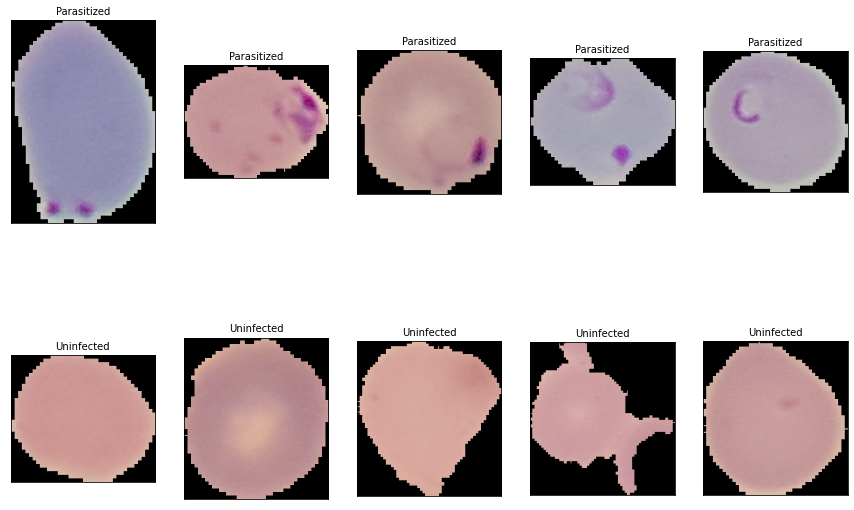

In [6]:
plot_images(data_directory = data_directory, labels = ['Parasitized', 'Uninfected'], count = 5)

# 3. Train-Test-Validation Sets

In [7]:
def train_validation_split(data_directory = data_directory, target_size = (224,224), class_mode = "categorical", train_batch_size = 32, validation_batch_size = 256):
  generated_data_specs = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=45, shear_range=16, rescale=1/255.0, validation_split=0.2)

  training_data = generated_data_specs.flow_from_directory( data_directory, target_size=target_size, class_mode=class_mode, batch_size=train_batch_size, 
                                                            shuffle=True, seed=42, subset='training')

  validation_data = generated_data_specs.flow_from_directory(data_directory, target_size=target_size, class_mode=class_mode, batch_size=validation_batch_size, 
                                                                  shuffle=True, seed=42, subset='validation')
  return training_data, validation_data


In [8]:
training_batch_size = 32
validation_batch_size = 256
training_data, validation_data = train_validation_split(train_batch_size= training_batch_size, validation_batch_size=validation_batch_size)

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


# 5. Hyper Parameter Settings

In [9]:
loss = 'categorical_crossentropy'
metrics = ['acc']
learning_rate = 0.0001
optimizer = Adam(learning_rate)
epochs = 10

In [10]:
def get_callbacks(i):
  tensor_directory = "logs/fit/"+i+"/"+time.strftime('%Y-%m-%d::%H-%M-%S')
  tensorboard_callback= keras.callbacks.TensorBoard( log_dir=tensor_directory, histogram_freq=1)
  checkpoint_path = "/content/check_point/"+i+"_weights.hdf5"
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint( filepath=checkpoint_path, save_weights_only=True, monitor='val_acc', mode='max',
                                                                save_best_only=True)
  return [model_checkpoint_callback, tensorboard_callback]

# 7. Model

In [11]:
def get_model(input_shape, model_name, include_top = False, freeze_layers = 0):
    inputs = Input(input_shape)
    if model_name == "InceptionResNet":
      base_model = InceptionResNetV2(include_top=include_top, input_shape=input_shape)
    elif model_name == "DenseNet201":
      base_model = DenseNet201(include_top=include_top, input_shape=input_shape)
    elif model_name == "VGG19":
      base_model = VGG19(include_top=include_top, input_shape=input_shape)
    else:
      print("Enter InceptionResNet, NasNetLarge or DenseNet201")
      return None

    for layer in base_model.layers[:-1*freeze_layers]:
      layer.trainable = False

    x = base_model(inputs)
    output1 = GlobalMaxPooling2D()(x)
    output2 = GlobalAveragePooling2D()(x)
    output3 = Flatten()(x)
    
    outputs = Concatenate(axis=-1)([output1, output2, output3])
    
    outputs = Dropout(0.5)(outputs)
    outputs = BatchNormalization()(outputs)
    
    outputs = Dense(2, activation="softmax")(outputs)
        
    model = Model(inputs, outputs)
    model.summary()
    return model

In [12]:
print("Getting Base Model", date_time())
def train_models():
  input_shape = (224, 224, 3)
  model_name = ["VGG19", "InceptionResNet","DenseNet201"]
  for i in model_name:
    model = get_model(input_shape=input_shape,model_name = i , freeze_layers = 25)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    print("Get call backs")
    callbacks = get_callbacks(i)
    print("Started Fitting "+i, date_time())
    history = model.fit(
      training_data,
      epochs=epochs,
      validation_data=validation_data, 
      steps_per_epoch = training_data.samples // training_batch_size,
    validation_steps = validation_data.samples // validation_batch_size,
    verbose = 1,
    callbacks=callbacks
      )
    print("ended fitting"+i)

    model_path = "/content/models/"+i
    model.save(model_path,overwrite=True,include_optimizer=True)
    model = None
    print("weights saved")

Getting Base Model Timestamp: 2020-10-22 08:23:39


In [13]:
#train_models()

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
%cp -avr /content/drive/My\ Drive/models /content/

'/content/drive/My Drive/models' -> '/content/models'
'/content/drive/My Drive/models/VGG19' -> '/content/models/VGG19'
'/content/drive/My Drive/models/VGG19/variables' -> '/content/models/VGG19/variables'
'/content/drive/My Drive/models/VGG19/variables/variables.data-00000-of-00001' -> '/content/models/VGG19/variables/variables.data-00000-of-00001'
'/content/drive/My Drive/models/VGG19/variables/variables.index' -> '/content/models/VGG19/variables/variables.index'
'/content/drive/My Drive/models/VGG19/assets' -> '/content/models/VGG19/assets'
'/content/drive/My Drive/models/VGG19/saved_model.pb' -> '/content/models/VGG19/saved_model.pb'
'/content/drive/My Drive/models/InceptionResNet' -> '/content/models/InceptionResNet'
'/content/drive/My Drive/models/InceptionResNet/variables' -> '/content/models/InceptionResNet/variables'
'/content/drive/My Drive/models/InceptionResNet/variables/variables.index' -> '/content/models/InceptionResNet/variables/variables.index'
'/content/drive/My Drive

In [16]:
%cp -avr /content/drive/My\ Drive/logs /content/

'/content/drive/My Drive/logs' -> '/content/logs'
'/content/drive/My Drive/logs/fit' -> '/content/logs/fit'
'/content/drive/My Drive/logs/fit/VGG19' -> '/content/logs/fit/VGG19'
'/content/drive/My Drive/logs/fit/VGG19/2020-10-21::14-40-11' -> '/content/logs/fit/VGG19/2020-10-21::14-40-11'
'/content/drive/My Drive/logs/fit/VGG19/2020-10-21::14-40-11/train' -> '/content/logs/fit/VGG19/2020-10-21::14-40-11/train'
'/content/drive/My Drive/logs/fit/VGG19/2020-10-21::14-40-11/train/events.out.tfevents.1603291223.3b1b847268a2.profile-empty' -> '/content/logs/fit/VGG19/2020-10-21::14-40-11/train/events.out.tfevents.1603291223.3b1b847268a2.profile-empty'
'/content/drive/My Drive/logs/fit/VGG19/2020-10-21::14-40-11/train/plugins' -> '/content/logs/fit/VGG19/2020-10-21::14-40-11/train/plugins'
'/content/drive/My Drive/logs/fit/VGG19/2020-10-21::14-40-11/train/plugins/profile' -> '/content/logs/fit/VGG19/2020-10-21::14-40-11/train/plugins/profile'
'/content/drive/My Drive/logs/fit/VGG19/2020-10-21

In [17]:
def load_models(path, model_name):
  models = []
  for i in model_name:
    print(i)
    models.append(keras.models.load_model(path+i))
  return models

In [18]:
model_path = '/content/models/'

In [19]:
model_names=['DenseNet201','InceptionResNet','VGG19']
models = load_models(model_path,model_names)

DenseNet201
InceptionResNet
VGG19


In [21]:
'''labels = []
for model in models:
  print(f"prediction started")
  predicts = np.argmax(model.predict(validation_data), axis = 1)
  labels.append(predicts)
labels = np.array(labels)'''

'labels = []\nfor model in models:\n  print(f"prediction started")\n  predicts = np.argmax(model.predict(validation_data), axis = 1)\n  labels.append(predicts)\nlabels = np.array(labels)'

In [22]:
import cv2

In [33]:
test_data_generate = ImageDataGenerator(rescale = 1.0/255,validation_split=0.20)
test_data = test_data_generate.flow_from_directory(data_directory, target_size=(224,224), class_mode="categorical", batch_size=128,shuffle = False,seed = 48,
                                                   subset='validation')

Found 5510 images belonging to 2 classes.


In [34]:
'''path = test_data.filepaths
labels = test_data.labels
for i,j in zip(path, labels):
  xtest.appendcv2.imread()
Y = test_data.names'''

'path = test_data.filepaths\nlabels = test_data.labels\nfor i,j in zip(path, labels):\n  xtest.appendcv2.imread()\nY = test_data.names'

In [35]:
len(test_data.filepaths)

5510

In [36]:
labels = []
for model,name in zip(models, model_names):
  print("********************************************************")
  print(f"testing {name} started\n")
  predicted = np.argmax(model.predict(test_data, verbose=1),axis = 1)
  print(predicted)
  labels.append(predicted)
  print(f"testing {name} completed")

labels = np.array(labels)

********************************************************
testing DenseNet201 started

44/44 [==============================] - 13s 288ms/step
[0 0 0 ... 1 1 1]
testing DenseNet201 completed
********************************************************
testing InceptionResNet started

44/44 [==============================] - 15s 338ms/step
[0 0 0 ... 1 1 1]
testing InceptionResNet completed
********************************************************
testing VGG19 started

44/44 [==============================] - 12s 284ms/step
[0 0 0 ... 1 1 1]
testing VGG19 completed


In [37]:
labels

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

In [38]:
labels = scipy.stats.mode(labels)[0]
labels = labels.T

In [39]:
accuracy = accuracy_score(validation_data.labels,predicted)
precision = precision_score(validation_data.labels,predicted)
recall = recall_score(validation_data.labels,predicted)
f1 = f1_score(validation_data.labels,predicted)
roc =roc_auc_score(validation_data.labels,predicted)
matrix = confusion_matrix(validation_data.labels,predicted)

In [40]:
print(f"accuracy score = {accuracy*100}")
print(f"Precision score = {precision*100}")
print(f"Recall score = {recall*100}")
print(f"F1 score = {f1*100}")
print(f"ROC score = {roc*100}")

accuracy score = 95.24500907441016
Precision score = 94.56560600643546
Recall score = 96.00725952813067
F1 score = 95.28097982708934
ROC score = 95.24500907441016


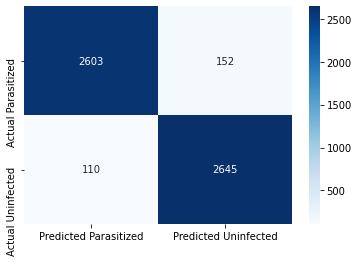

In [41]:
%matplotlib inline
import seaborn as sns
sns.heatmap(matrix, annot=True,cmap='Blues', fmt='g', xticklabels = ["Predicted Parasitized","Predicted Uninfected"], yticklabels=["Actual Parasitized","Actual Uninfected"])

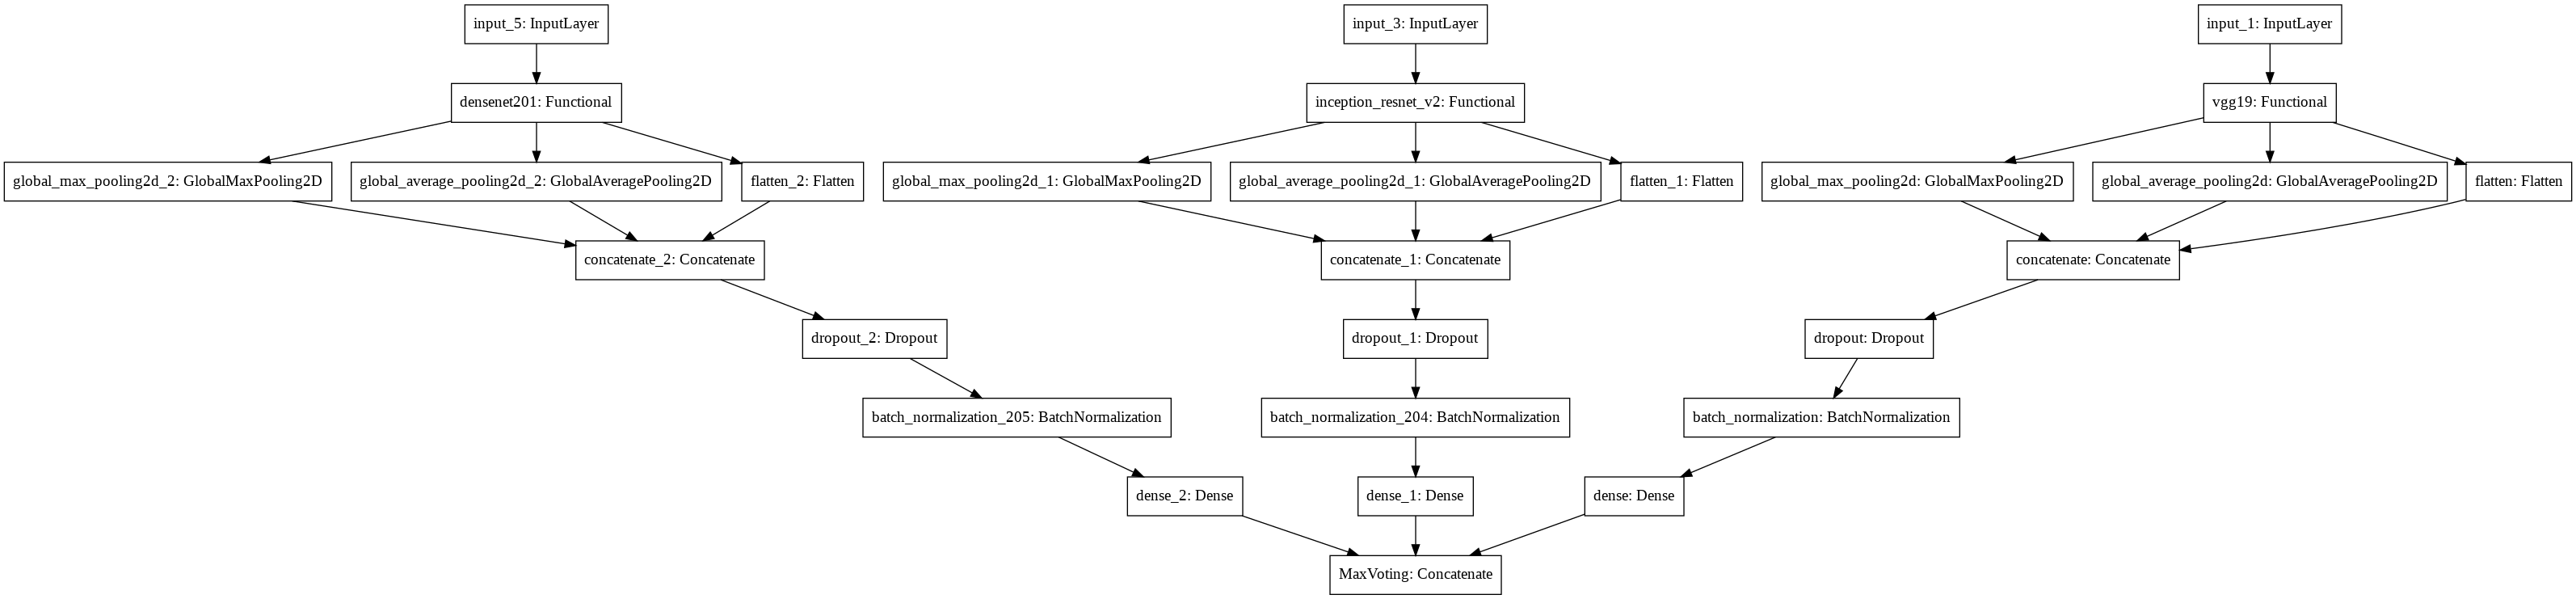

In [42]:
'''Just created for putting image in the term paper'''
outputs = Concatenate(axis=-1,name = 'MaxVoting')([x.output for x in models])
mega_classifier = Model(inputs=[x.input for x in models],outputs=outputs)
plot_model(mega_classifier)

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir '/content/logs/fit/'